# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Model Evaluation & Feature Importance
Week 6| Lesson 3.3

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Explain how feature importance is calculated for decision trees
- Calculate feature importance manually
- Extract feature importance with scikit-learn
- Extend the calculation to ensemble models (RF, ET)

In [37]:
!pwd

/Users/jam3jam/dsi/GA-DSI/dsi-course-materials/curriculum/04-lessons/week-06/3.3-lesson/assets


### STUDENT PRE-WORK
*Before this lesson, you should already be able to:*
- Perform a classification with Decision Trees
- Perform a classification with Random Forest
- Perform a classification with Extra Trees

### INSTRUCTOR PREP
*Before this lesson, instructors will need to:*
- Read in / Review any dataset(s) & starter/solution code
- Generate a brief slide deck
- Prepare any specific materials
- Provide students with additional resources

### LESSON GUIDE
| TIMING  | TYPE  | TOPIC  |
|:-:|---|---|
| 5 mins | [Opening](#opening) | Opening |
| 20 min | [Introduction](#introduction) | Feature importance for non-parametric models |
| 30 min | [Demo](#demo) | Demo: Feature importance in Decision Trees |
| 25 min | [Guided-practice](#guided-practice) | Guided Practice: Feature importance in Ensemble models |
| 5 min | [Conclusion](#conclusion) | Conclusion |


<a name="opening"></a>
## Opening (5 mins)
Today we will discuss feature importance for tree based models. When we build a machine learning model we are not only interested in pure prediction accuracy. More often than not we are building a model to get insights on what the relevant predictor variables are.

E.g. you have 1000 features to predict user retention.
Which features are relevant? Can you identify them? Can you build marketing strategies to address them?

**Check:** How did we assess feature importance for Logistic Regression?
> Answer: We looked at the size of coefficients when the features were normalized.

<a name="introduction"></a>
## Feature importance for non-parametric models (20 min)

We previously discussed feature selection in the context of Logistic Regression. Logistic Regression is a parametric model, which means that our hypothesis is described in terms of coefficients that we tune to improve the model's accuracy. In particular, since LR is a linear model, each parameter is associated to a specific feature. Thus, if the features are normalized, we can interpret the size of each coefficient to indicate the relative importance of that specific feature.

**Check:** We also discussed how Scikit-Learn implements several methods for feature selection. In pairs: discuss with a partner if what methods you remember for feature selections. For each method that you can remember come up with a one line description of how it works.
> Answer: we discussed:
- Univariate feature selection
- Recursive feature elimination
- L1-based feature selection

### Decision Trees
Tree based models are non-parametric, thus we don't have coefficients to tune like we did in linear models. We can however still ask which of the features are more important.

**Check:** How does a tree decide which split to perform?
> Answer: The decision tree algorithm makes locally optimal choices to maximize the gain in purity after the choice with respect to before the choice.

**Check:** We learned about several ways to measure impurity. Do you remember any?
> Answer: For classification we discussed Gini impurity and information gain/entropy.
> For regression trees we used Mean Squared Error.

When training a tree, we can compute how much each feature decreases the weighted impurity by adding up all the impurity gains where such a feature is used to determine a split. In other words, the importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.


### Random Forest

**Check:** How would you extend the definition of feature importance from decision trees to random forests? In pairs: discuss with your partner and come up with a suggestion or idea.
> Answer: we can calculate the feature importance for each tree in the forest and then average the importances across the whole forest. A random forest is an ensemble of trees trained on random samples and random subsets of features. Thus, for each tree a feature importance can be calculated using the same procedure outlined above. Then the results are averaged over the whole forest.



<a name="demo"></a>
## Demo: Feature importance in Decision Trees (30 min)

We will use again the Car Dataset model that was introduced before. Suppose you are working at a car company and you are tasked to identify which features drive the acceptability of a car. You have collected some data on several features including:

    - PRICE                  overall price
        - buying             buying price
        - maint              price of the maintenance
    - TECH                   technical characteristics
        - COMFORT            comfort
            - doors          number of doors
            - persons        capacity in terms of persons to carry
            - lug_boot       the size of luggage boot
        - safety             estimated safety of the car

Feature values are:

    buying       v-high, high, med, low
    maint        v-high, high, med, low
    doors        2, 3, 4, 5-more
    persons      2, 4, more
    lug_boot     small, med, big
    safety       low, med, high

Class Distribution (number of instances per class)

    class      N          N[%]
    -----------------------------
    unacc     1210     (70.023 %) 
    acc        384     (22.222 %) 
    good        69     ( 3.993 %) 
    v-good      65     ( 3.762 %) 


**Check:** Which steps do we need to perform in order to evaluate feature importance with a decision tree model? Can you list them?
> Answer:
- load data
- map features to binary variables
- map labels to numbers
- train a decision tree classifier
- inspect feature importance

First of all let's load it and map it to binary features.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
df = pd.read_csv('./assets/datasets/car.csv')
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


This time we will encode the features using a One Hot encoding scheme, i.e. we will consider them as categorical variables.

Since Scikit-Learn doesn't understand strings, but only numbers we will also need to map the labels to numbers. We can use the `LabelEncoder` we've encountered other times.

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['acceptability'])
X = pd.get_dummies(df.drop('acceptability', axis=1))

Let's train a decision tree on the whole dataset (ignore overfitting for the moment). Let's also artificially constrain the tree to be small so that we can visualize it.

In [3]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2)

dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

**Check:** What does the next line of code do?
>Answer: How many values there are for each class

In [4]:
pd.Series(y).value_counts()

2    1210
0     384
1      69
3      65
dtype: int64

Let's visualize the tree using the graphviz exporter. We have encountered this in the class on decision trees.

**Check:** can you fill the blanks?

> Answer:
>
    export_graphviz(dt, out_file=dot_data,  
                    feature_names=X.columns,  
                    class_names=le.classes_,  
                    filled=True, rounded=True,
                    proportion=True,
                    special_characters=True)  


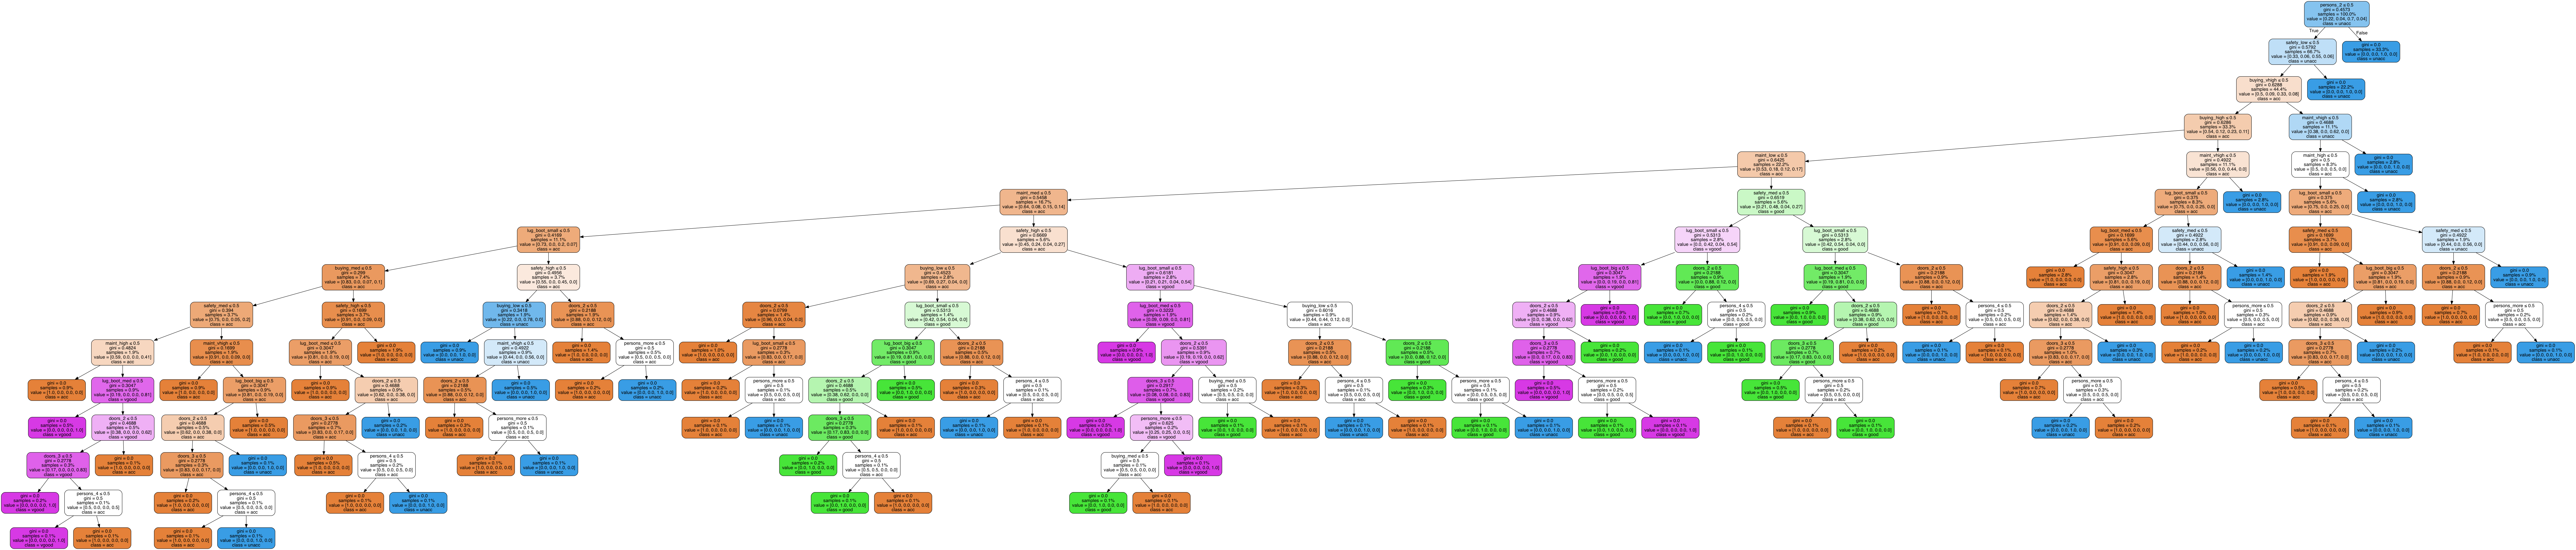

In [19]:
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image
dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data,  
               feature_names=X.columns,  
               class_names=le.classes_,  
               filled=True, rounded=True,
               proportion=True,
               special_characters=True) 
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

The first choice involves `person_2`. If the car only takes 2 people (`person_2` == 1) then the class is unacceptable. This happens in 33% of the cases. Note that the leaf under the `False` branch is 100% pure, and therefore it's Gini measure is 0.0.

On the other hand, if the car can hold more than 2 people, we will need to consider other choices. For example if the car is unsafe, then it's also unacceptable. And so on and so forth.

**Check:** Open discussion: what could be an advantage of using a decision tree in a model at work?
> Answer: easier to communicate results and understand relevant features.

If the target is a classification taking values 0, 1, ... K-2, K-1. If node $m$ represents a region $R_m$ with $N_m$ observations, the proportion of class $k$ observations in node $m$ can be written as:
$$
        C_k = \frac{1}{N_m} \sum_{x_i\text{ in }R_m} I(y_i = k)
$$
The Gini Index is then defined as:
$$
        \text{Gini}= \sum_{k=0}^{K-1} C_k (1 - C_k)
              = 1 - \sum_{k=0}^{K-1} C_k^2
$$

Let's plot the gini index for various proportions in a binary classification:

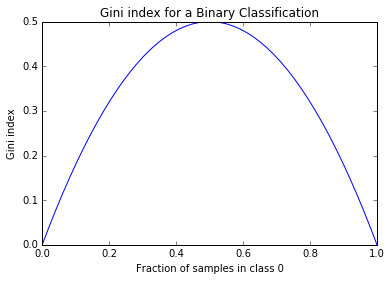

In [20]:
C0 = np.linspace(0,1)
C1 = 1.0 - C0

gini = 1 - C0**2 - C1**2

plt.plot(C0, gini)
plt.title('Gini index for a Binary Classification')
plt.xlabel('Fraction of samples in class 0')
plt.ylabel('Gini index')

Let's verify the calculation of the Gini index in the root node of the tree above:

In [21]:
root_node_values = [0.22, 0.04, 0.7, 0.04]

def gini(values):
    tot = 0.0
    for val in values:
        tot += val ** 2
    
    return 1.0 - tot

gini(root_node_values)

0.45840000000000003

**Check:** Check that the value we obtained is the same as the one appearing in our decision tree.

Great, now we are ready to look at feature importances in our tree:

In [22]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
safety_low,0.233312
persons_2,0.155542
lug_boot_small,0.094315
maint_vhigh,0.082496
safety_med,0.060337


Since we artificially constricted the tree to be small, only 3 features are used to make splits. Let's verify the calculation of the importance.

In [23]:
gini_gain_persons_2  = 1.0   * 0.45728376  - 0.667 * 0.57923569 - 0.333 * 0.0
gini_gain_safety_low   = 0.666 * 0.57923569 - 0.444 * 0.62880113 - 0.222 * 0.0
gini_gain_buying_vhigh = 0.444 * 0.62880113 - 0.333 * 0.6285747 - 0.111 * 0.46875

norm = gini_gain_persons_2 + gini_gain_safety_low + gini_gain_buying_vhigh

print "persons_2:", gini_gain_persons_2 / norm
print "safety_low:", gini_gain_safety_low / norm
print "buying_vhigh:", gini_gain_buying_vhigh / norm

persons_2: 0.363095401091
safety_low: 0.545579514578
buying_vhigh: 0.0913250843306


**Check:** what did we just do and why did we do that?
>Answer: We verified the calculation of gini gain corresponds to the feature importance outputed by the decision tree model.

<a name="guided-practice"></a>
## Guided Practice: Feature importance in Ensemble models (25 min)

Scikit Learn implements feature importance for random forest and extra trees methods.

Let's train one of each of these and investigate the feature importance:

- Random Forest
- Extra Trees

> Instructor: This could be done in small groups where they have to fill the blanks of missing code

In [24]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Random forest exposes the feature importance and it calculates it as the average feature importance of the trees. Let's verify that.

Fill the blanks in the code below:

> Solution:
>
    all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))
>
    importances = rf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
>
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns

(-1, 21)

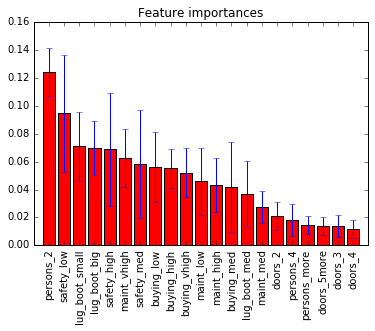

In [31]:
all(rf.feature_importances_ == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

Now it's your turn: repeat the investigation for the extra trees model.

> Solution:
>
    et.fit(X, y)
>
    importances = et.feature_importances_
    std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)
>
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns
>
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])

(-1, 21)

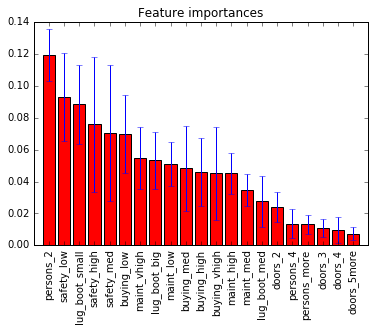

In [34]:
et.fit(X, y)

importances = et.feature_importances_
std = np.std([tree.feature_importances_ for tree in et.estimators_], axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

Finally let's compare the 3 models (re-init Decision Tree)

,dt_importance,rf_importance,et_importance
persons_2,0.233312,0.124442,0.119139
safety_low,0.155542,0.094548,0.092898
lug_boot_small,0.069452,0.070846,0.088353
lug_boot_big,0.007830,0.069936,0.053251
safety_high,0.091953,0.068847,0.075772


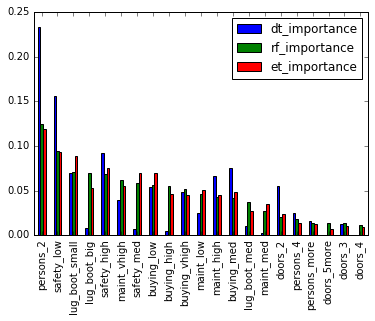

In [35]:
dt = DecisionTreeClassifier()
dt.fit(X, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar')
importances.head()

**Check:** Discuss in small groups the plot above. What are the common thigns across all models? What are the differences?

<a name="conclusion"></a>
## Conclusion (5 min)

In this class we learned about feature importance and how they are calculated for tree based models.
We have also deepened our understanding of the Gini measure.

**Check:** How can you use this in practice?
> Answer: have them discuss about feature selection and communicating results to peers

### ADDITIONAL RESOURCES

- [Gini Importance](http://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#giniimp)
- [DT Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [Feature Importance in Sklearn Blog](http://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/)
- [Plot Feature Importances example](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
- [Selecting good features](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/)